In [ ]:
!unzip poses.zip

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
import torchvision
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Subset
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
class YogaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(class_name for class_name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, class_name)))

        # Create a list of file paths and labels
        self.file_paths = []
        self.labels = []
        for idx, pose_class in enumerate(self.classes):
            pose_folder = os.path.join(self.root_dir, pose_class, "train")
            file_names = [file_name for file_name in os.listdir(pose_folder) if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.file_paths.extend([os.path.join(pose_folder, file_name) for file_name in file_names])
            self.labels.extend([idx] * len(file_names))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

In [8]:
# Define a series of image transformations
data_transforms = transforms.Compose([
    # Convert the input image array to a PIL Image
    # transforms.ToPILImage(),
    # Resize the image to a square of size 256x256 pixels
    transforms.Resize(256),
    # Apply random color jittering to the image
    transforms.ColorJitter(),
    # Randomly crop the image to a size of 224x224 pixels
    transforms.RandomCrop(224),
    # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomHorizontalFlip(),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Create the dataset
dataset = YogaDataset(root_dir='poses', transform=data_transforms)

print(len(dataset))

# Extract labels
labels = dataset.labels

# Perform a stratified split to maintain equal representation of each class
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=labels, random_state=42)

# Further split the training set into training and validation
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, stratify=[labels[i] for i in train_indices], random_state=42)

# Create subsets based on the indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print("Training Set length: ", len(train_dataset))
print("Validation Set length: ", len(val_dataset))
print("Test Set length: ", len(test_dataset))

1359
Training Set length:  869
Validation Set length:  218
Test Set length:  272


In [10]:
# Function to display images
def show_images(images, labels, classes):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))

    for i in range(len(images)):
        image = images[i].permute(1, 2, 0)  # Change the order of dimensions for displaying with matplotlib
        label = classes[labels[i].item()]

        axs[i].imshow(image)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.show()

In [11]:
# We are defining the batch size as 32
# Create a data loader for the training dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=32, pin_memory=True, shuffle=True)
# Create a data loader for the validation dataset
val_loader = DataLoader(dataset=val_dataset, pin_memory=True)
# Create a data loader for the test dataset
test_loader = DataLoader(dataset=test_dataset, pin_memory=True)

torch.Size([3, 224, 224])


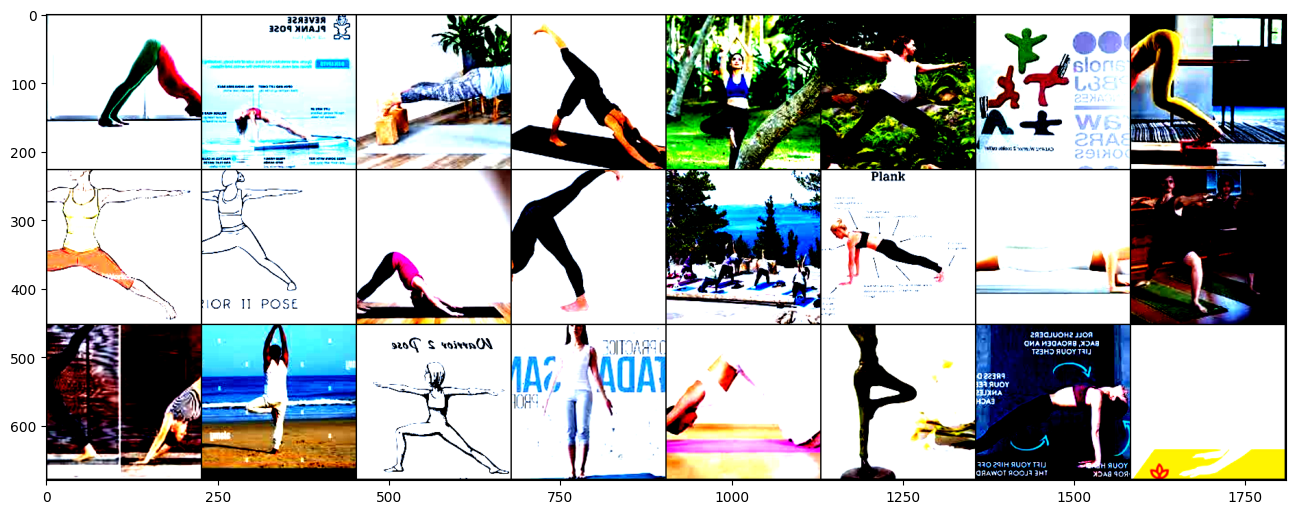

In [14]:
# Printing some sample images from the training dataset(images are normalized)
samples, labels = next(iter(train_loader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
print(samples[0].shape)

In [20]:
def plot_loss(val_losses, num_epochs, title):
    # Plot the training and validation losses
    epochs = np.arange(1, num_epochs + 1)
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# **ResNet18**

In [12]:
# Load ResNet18 with pretrained weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Print the architecture
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Modify the last layer for this specific case of classification
model.fc = nn.Sequential(
    nn.Linear(512, 5),
    nn.Sigmoid()
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
# Last FC layer
for param in model.fc.parameters():
    param.requires_grad = True

In [15]:
# Define loss function and optimizer
# We are going to use the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# We are using a Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model (first stage)
num_epochs = 10
best_val_acc = 0.0
# Number of epochs to wait for improvement before stopping
patience = 3
# Counter for patience
counter = 0

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    # Load inputs, labels from each batch of training set
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        # Move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # This method is used to reset the gradients of the model's parameters before computing gradients in a new forward pass
        optimizer.zero_grad()
        # This is the forward propagation of the Resnet18 model.
        outputs = model(inputs)
        # Calculating the cross-entropy loss for this forward pass.
        loss = criterion(outputs, labels)
        # This step initiates the process of backpropagation, where gradients are computed for each parameter in the model with respect to the loss.
        # Backpropagation calculates how much each parameter should be adjusted to reduce the loss.
        loss.backward()
        # It is used to update the model's parameters (weights and biases) based on the gradients computed during the backward pass (backpropagation)/previous step.
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    # This disables gradient computation and updates
    with torch.no_grad():
        # variable to track total loss
        total_loss = 0
        # variable to track correct predictions
        correct_val = 0
        # variable to track size of validation set
        total_val = 0
        # Looping through each batch in validation set
        for inputs_val, labels_val in val_loader:
            # Move the data to GPU
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            # This is the forward propagation of the model
            outputs_val = model(inputs_val)
            # Get the class associated with the maximum value/probability
            _, predicted_val = torch.max(outputs_val, 1)
            # Updating the total loss with the loss of the batch
            total_loss += loss.item()
            # Updating the total size of validations set
            total_val += labels_val.size(0)
            # Updating the total correct predictions
            correct_val += (predicted_val == labels_val).sum()

        # Calculate the validation loss by dividing the total validation loss by the validation set size
        validation_loss = total_loss / len(val_loader)
        # Calculating the validation accuracy
        val_acc = (correct_val / total_val) * 100
        print(f"Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_resnet18.pth")
            # reset the counter
            counter = 0
        else:
            # Early Stopping
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/10: 100%|██████████| 28/28 [00:11<00:00,  2.42batch/s]


Epoch 1, Validation Loss: 1.5890, Validation Accuracy: 41.74%


Epoch 2/10: 100%|██████████| 28/28 [00:02<00:00,  9.73batch/s]


Epoch 2, Validation Loss: 1.4569, Validation Accuracy: 54.59%


Epoch 3/10: 100%|██████████| 28/28 [00:03<00:00,  7.26batch/s]


Epoch 3, Validation Loss: 1.5511, Validation Accuracy: 62.39%


Epoch 4/10: 100%|██████████| 28/28 [00:02<00:00,  9.83batch/s]


Epoch 4, Validation Loss: 1.3624, Validation Accuracy: 58.72%


Epoch 5/10: 100%|██████████| 28/28 [00:02<00:00,  9.76batch/s]


Epoch 5, Validation Loss: 1.3769, Validation Accuracy: 62.84%


Epoch 6/10: 100%|██████████| 28/28 [00:03<00:00,  7.11batch/s]


Epoch 6, Validation Loss: 1.4218, Validation Accuracy: 66.51%


Epoch 7/10: 100%|██████████| 28/28 [00:02<00:00,  9.64batch/s]


Epoch 7, Validation Loss: 1.1544, Validation Accuracy: 63.76%


Epoch 8/10: 100%|██████████| 28/28 [00:02<00:00,  9.80batch/s]


Epoch 8, Validation Loss: 1.4393, Validation Accuracy: 68.81%


Epoch 9/10: 100%|██████████| 28/28 [00:04<00:00,  6.95batch/s]


Epoch 9, Validation Loss: 1.4611, Validation Accuracy: 66.51%


Epoch 10/10: 100%|██████████| 28/28 [00:02<00:00,  9.74batch/s]


Epoch 10, Validation Loss: 1.3583, Validation Accuracy: 69.27%


In [16]:
# Load the best model
model.load_state_dict(torch.load("best_model_resnet18.pth"))

# Lists to store incorrect predictions
incorrect_images = []
incorrect_labels = []
correct_labels = []

# Evaluate the model on the test set
model.eval()
# Testing
# This disables gradient computation and updates
with torch.no_grad():
    # Variables for tracking the size of test set and the number of correct predictions in test set
    correct_test = 0
    total_test = 0
    # Looping through each batch in test set
    for inputs_test, labels_test in test_loader:
        # Move the data to GPU
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        # This is the forward propagation of the model
        outputs_test = model(inputs_test)
        # Get the class associated with the maximum value/probability
        _, predicted_test = torch.max(outputs_test, 1)
        # Storing incorrect prediction details
        if predicted_test != labels_test:
            incorrect_images.append(inputs_test[predicted_test != labels_test].cpu().numpy())
            incorrect_labels.append(predicted_test[predicted_test != labels_test].cpu().numpy())
            correct_labels.append(labels_test[predicted_test != labels_test].cpu().numpy())
        # Updating the total size of test set
        total_test += labels_test.size(0)
        # Updating the total correct predictions
        correct_test += (predicted_test == labels_test).sum()

test_acc = (correct_test / total_test) * 100
print(f"Total: {total_test}")
print(f"correct: {correct_test}")
print(f"Test Accuracy (after freezing layers): {test_acc}")

Total: 272
correct: 182
Test Accuracy (after freezing layers): 66.9117660522461


In [17]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [18]:
model.load_state_dict(torch.load("best_model_resnet18.pth"))

# Define loss function and optimizer
# We are going to use the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# We are using a Adam optimizer with a learning rate of 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model (first stage)
num_epochs = 15
best_val_acc = 0.0
# Number of epochs to wait for improvement before stopping
patience = 6
# Counter for patience
counter = 0
val_losses = []

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    # Load inputs, labels from each batch of training set
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        # Move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # This method is used to reset the gradients of the model's parameters before computing gradients in a new forward pass
        optimizer.zero_grad()
        # This is the forward propagation of the Resnet18 model.
        outputs = model(inputs)
        # Calculating the cross-entropy loss for this forward pass.
        loss = criterion(outputs, labels)
        # This step initiates the process of backpropagation, where gradients are computed for each parameter in the model with respect to the loss.
        # Backpropagation calculates how much each parameter should be adjusted to reduce the loss.
        loss.backward()
        # It is used to update the model's parameters (weights and biases) based on the gradients computed during the backward pass (backpropagation)/previous step.
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    # This disables gradient computation and updates
    with torch.no_grad():
        # variable to track total loss
        total_loss = 0
        # variable to track correct predictions
        correct_val = 0
        # variable to track size of validation set
        total_val = 0
        # Looping through each batch in validation set
        for inputs_val, labels_val in val_loader:
            # Move the data to GPU
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            # This is the forward propagation of the model
            outputs_val = model(inputs_val)
            # Get the class associated with the maximum value/probability
            _, predicted_val = torch.max(outputs_val, 1)
            # Updating the total loss with the loss of the batch
            total_loss += loss.item()
            # Updating the total size of validations set
            total_val += labels_val.size(0)
            # Updating the total correct predictions
            correct_val += (predicted_val == labels_val).sum()

        # Calculate the validation loss by dividing the total validation loss by the validation set size
        validation_loss = total_loss / len(val_loader)
        val_losses.append(validation_loss)
        # Calculating the validation accuracy
        val_acc = (correct_val / total_val) * 100
        print(f"Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_resnet18_fine_tuned.pth")
            # reset the counter
            counter = 0
        else:
            # Early Stopping
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/15: 100%|██████████| 28/28 [00:04<00:00,  6.09batch/s]


Epoch 1, Validation Loss: 1.3175, Validation Accuracy: 79.36%


Epoch 2/15: 100%|██████████| 28/28 [00:04<00:00,  6.51batch/s]


Epoch 2, Validation Loss: 1.0454, Validation Accuracy: 79.82%


Epoch 3/15: 100%|██████████| 28/28 [00:03<00:00,  8.95batch/s]


Epoch 3, Validation Loss: 1.2546, Validation Accuracy: 84.40%


Epoch 4/15: 100%|██████████| 28/28 [00:03<00:00,  7.42batch/s]


Epoch 4, Validation Loss: 1.1574, Validation Accuracy: 86.24%


Epoch 5/15: 100%|██████████| 28/28 [00:03<00:00,  8.87batch/s]


Epoch 5, Validation Loss: 1.0923, Validation Accuracy: 84.40%


Epoch 6/15: 100%|██████████| 28/28 [00:03<00:00,  7.98batch/s]


Epoch 6, Validation Loss: 1.0684, Validation Accuracy: 84.86%


Epoch 7/15: 100%|██████████| 28/28 [00:03<00:00,  8.42batch/s]


Epoch 7, Validation Loss: 1.1734, Validation Accuracy: 84.86%


Epoch 8/15: 100%|██████████| 28/28 [00:04<00:00,  6.93batch/s]


Epoch 8, Validation Loss: 1.0785, Validation Accuracy: 86.70%


Epoch 9/15: 100%|██████████| 28/28 [00:04<00:00,  6.51batch/s]


Epoch 9, Validation Loss: 1.1191, Validation Accuracy: 85.78%


Epoch 10/15: 100%|██████████| 28/28 [00:03<00:00,  9.05batch/s]


Epoch 10, Validation Loss: 0.9411, Validation Accuracy: 83.03%


Epoch 11/15: 100%|██████████| 28/28 [00:03<00:00,  8.94batch/s]


Epoch 11, Validation Loss: 0.9402, Validation Accuracy: 83.49%


Epoch 12/15: 100%|██████████| 28/28 [00:04<00:00,  6.93batch/s]


Epoch 12, Validation Loss: 1.1977, Validation Accuracy: 84.86%


Epoch 13/15: 100%|██████████| 28/28 [00:03<00:00,  8.90batch/s]


Epoch 13, Validation Loss: 0.9581, Validation Accuracy: 83.49%


Epoch 14/15: 100%|██████████| 28/28 [00:03<00:00,  8.74batch/s]


Epoch 14, Validation Loss: 1.0360, Validation Accuracy: 84.86%
Early stopping at epoch 14


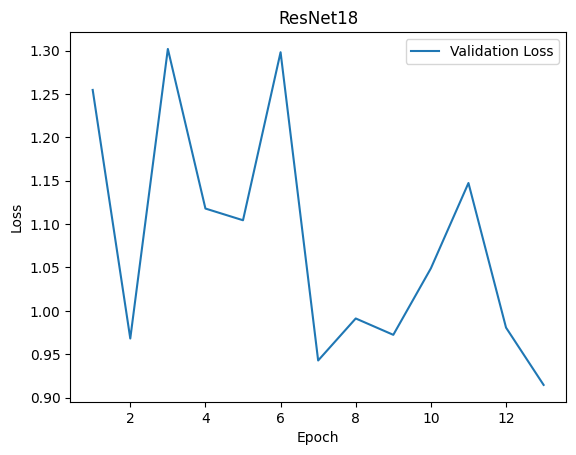

In [41]:
plot_loss(val_losses, 13, "ResNet18")


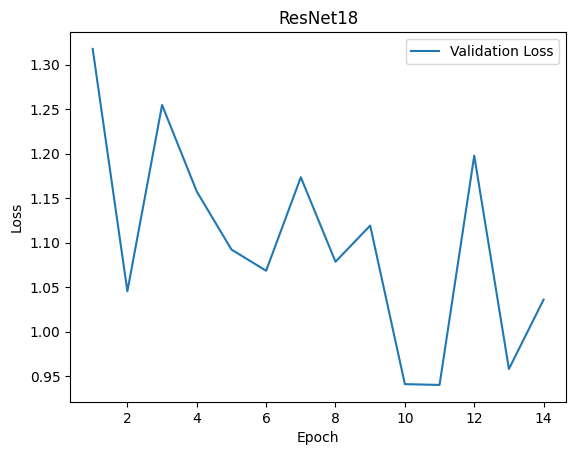

In [21]:
plot_loss(val_losses, 14, "ResNet18")

In [35]:
# Load the best model
model.load_state_dict(torch.load("best_model_resnet18_fine_tuned.pth"))

# Lists to store incorrect predictions
incorrect_images = []
incorrect_labels = []
correct_labels = []

correct_images = []
correct_l = []

# Evaluate the model on the test set
model.eval()
# Testing
# This disables gradient computation and updates
with torch.no_grad():
    # Variables for tracking the size of test set and the number of correct predictions in test set
    correct_test = 0
    total_test = 0
    # Looping through each batch in test set
    for inputs_test, labels_test in test_loader:
        # Move the data to GPU
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        # This is the forward propagation of the model
        outputs_test = model(inputs_test)
        # Get the class associated with the maximum value/probability
        _, predicted_test = torch.max(outputs_test, 1)
        # Storing incorrect prediction details
        if predicted_test != labels_test:
            incorrect_images.append(inputs_test[predicted_test != labels_test].cpu().numpy())
            incorrect_labels.append(predicted_test[predicted_test != labels_test].cpu().numpy())
            correct_labels.append(labels_test[predicted_test != labels_test].cpu().numpy())
        else:
            correct_images.append(inputs_test[predicted_test == labels_test].cpu().numpy())
            correct_l.append(labels_test[predicted_test == labels_test].cpu().numpy())
        # Updating the total size of test set
        total_test += labels_test.size(0)
        # Updating the total correct predictions
        correct_test += (predicted_test == labels_test).sum()

test_acc = (correct_test / total_test) * 100
print(f"Total: {total_test}")
print(f"correct: {correct_test}")
print(f"Test Accuracy (after freezing layers): {test_acc}")

Total: 272
correct: 216
Test Accuracy (after freezing layers): 79.4117660522461


In [24]:
# Convert lists to numpy arrays
incorrect_images_array = np.array(incorrect_images)
incorrect_labels_array = np.array(incorrect_labels)
correct_labels_array = np.array(correct_labels)

# Few sample wrong classifications
print(incorrect_images_array.shape)

# Reshape the array
reshaped_arr = incorrect_images_array.reshape((incorrect_images_array.shape[0], 3, 224, 224))

# Few sample wrong classifications
print(reshaped_arr.shape)

(52, 1, 3, 224, 224)
(52, 3, 224, 224)


In [36]:
# Convert lists to numpy arrays
correct_images_array = np.array(correct_images)
correct_l_array = np.array(correct_l)

# Few sample wrong classifications
print(correct_images_array.shape)

# Reshape the array
reshaped_arr = correct_images_array.reshape((correct_images_array.shape[0], 3, 224, 224))

# Few sample wrong classifications
print(reshaped_arr.shape)

(216, 1, 3, 224, 224)
(216, 3, 224, 224)


[array([2]), array([3]), array([1]), array([4]), array([3]), array([0]), array([4]), array([0]), array([4]), array([2]), array([2]), array([1]), array([0]), array([3]), array([4]), array([2])]


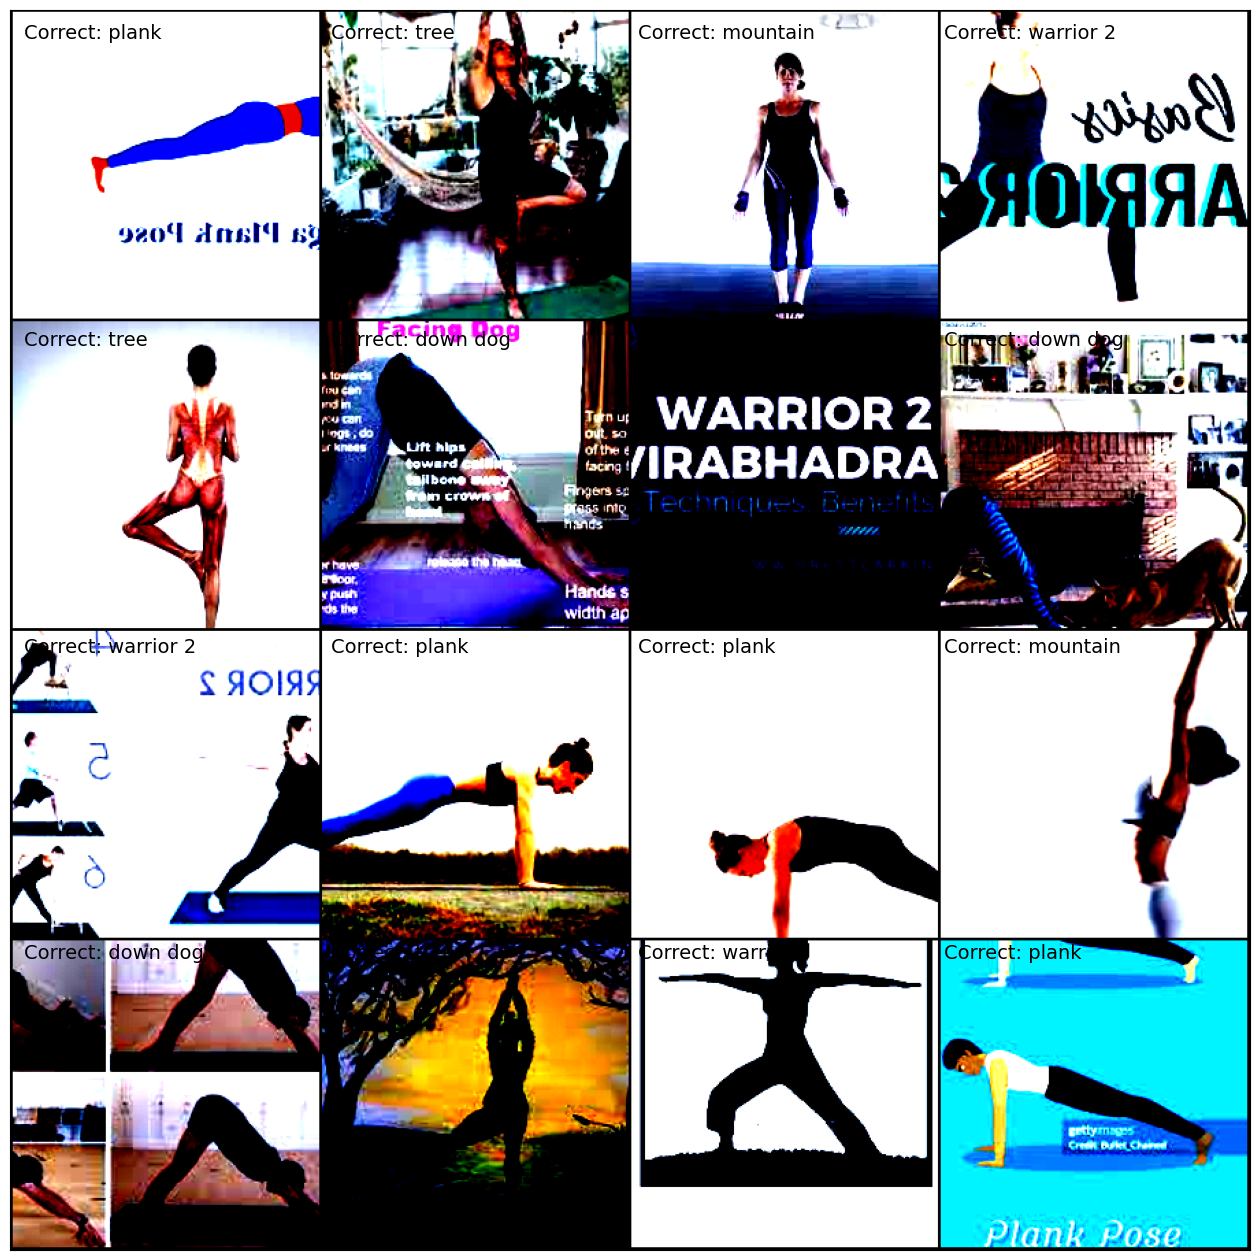

In [38]:
# Printing some sample images from the incorrect predictions
plt.figure(figsize=(16, 24))

# Select a subset of images to display
subset_images = reshaped_arr[:-200]
subset_correct_labels = correct_l[:-200]
# subset_predicted_labels = incorrect_labels[:24]
print(subset_correct_labels)

# Create a grid of images
grid_imgs = torchvision.utils.make_grid(torch.Tensor(subset_images), nrow=4)
np_grid_imgs = grid_imgs.numpy()

# Display the grid of images
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

lbls = ["down dog", "mountain", "plank", "tree", "warrior 2"]

# Display correct and predicted labels for each image
for i in range(len(subset_correct_labels)):
    # Add text on top of the image
    j = i%4
    k = i//4
    correct_label = lbls[subset_correct_labels[i][0]]
    # pred_label = lbls[subset_predicted_labels[i][0]]
    plt.text(j * 224 + 10, k*224+10, f'Correct: {correct_label}', color='black', fontsize=14, ha='left', va='top')
    # plt.text(j * 224 +10, k*224+40, f'Predicted: {pred_label}', color='black', fontsize=10, ha='left', va='top')

plt.show()

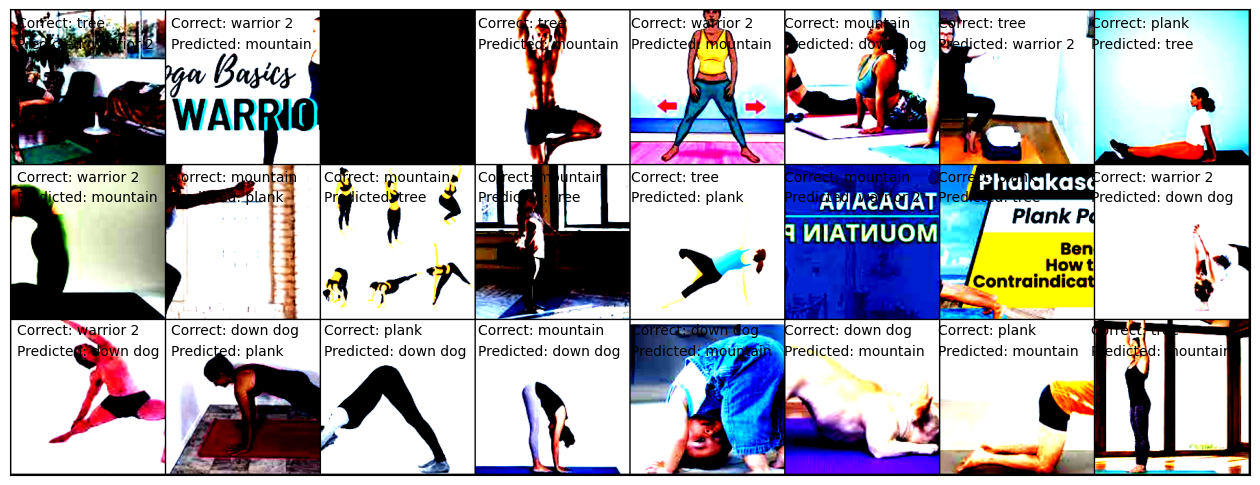

In [25]:
# Printing some sample images from the incorrect predictions
plt.figure(figsize=(16, 24))

# Select a subset of images to display
subset_images = reshaped_arr[:24]
subset_correct_labels = correct_labels[:24]
subset_predicted_labels = incorrect_labels[:24]


# Create a grid of images
grid_imgs = torchvision.utils.make_grid(torch.Tensor(subset_images))
np_grid_imgs = grid_imgs.numpy()

# Display the grid of images
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

lbls = ["down dog", "mountain", "plank", "tree", "warrior 2"]

# Display correct and predicted labels for each image
for i in range(len(subset_correct_labels)):
    # Add text on top of the image
    j = i%8
    k = i//8
    correct_label = lbls[subset_correct_labels[i][0]]
    pred_label = lbls[subset_predicted_labels[i][0]]
    plt.text(j * 224 + 10, k*224+10, f'Correct: {correct_label}', color='black', fontsize=10, ha='left', va='top')
    plt.text(j * 224 +10, k*224+40, f'Predicted: {pred_label}', color='black', fontsize=10, ha='left', va='top')

plt.show()

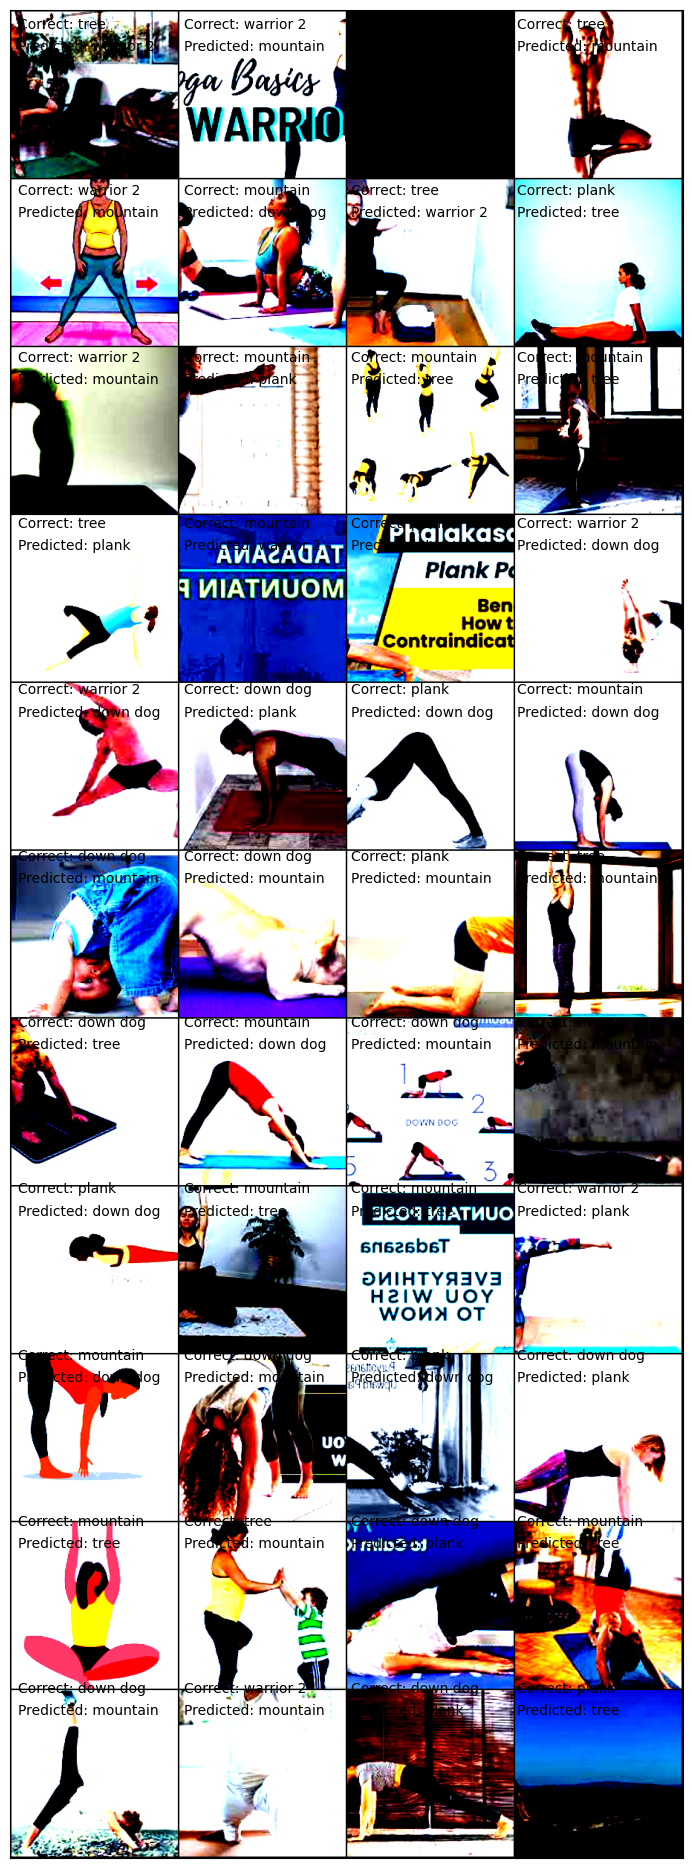

In [28]:
# Printing some sample images from the incorrect predictions
plt.figure(figsize=(16, 24))

# Select a subset of images to display
subset_images = reshaped_arr[:-8]
subset_correct_labels = correct_labels[:-8]
subset_predicted_labels = incorrect_labels[:-8]


# Create a grid of images
grid_imgs = torchvision.utils.make_grid(torch.Tensor(subset_images), nrow=4)
np_grid_imgs = grid_imgs.numpy()

# Display the grid of images
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

lbls = ["down dog", "mountain", "plank", "tree", "warrior 2"]

# Display correct and predicted labels for each image
for i in range(len(subset_correct_labels)):
    # Add text on top of the image
    j = i%4
    k = i//4
    correct_label = lbls[subset_correct_labels[i][0]]
    pred_label = lbls[subset_predicted_labels[i][0]]
    plt.text(j * 224 + 10, k*224+10, f'Correct: {correct_label}', color='black', fontsize=10, ha='left', va='top')
    plt.text(j * 224 +10, k*224+40, f'Predicted: {pred_label}', color='black', fontsize=10, ha='left', va='top')

plt.show()

# **VGG16**

In [43]:
# Load ResNet18 with pretrained weights
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# Print the architecture
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:23<00:00, 23.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
# Modify the last layer for this specific case of binary classification (cats vs. dogs)
# Modify the last fully connected layer for transfer learning
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Make the parameters of the last layer trainable
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [46]:
# Define loss function and optimizer
# We are going to use the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# We are using a Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model (first stage)
num_epochs = 10
best_val_acc = 0.0
# Number of epochs to wait for improvement before stopping
patience = 8
# Counter for patience
counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    # Load inputs, labels from each batch of training set
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        # Move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # This method is used to reset the gradients of the model's parameters before computing gradients in a new forward pass
        optimizer.zero_grad()
        # This is the forward propagation of the Resnet18 model.
        outputs = model(inputs)
        # Calculating the cross-entropy loss for this forward pass.
        loss = criterion(outputs, labels)
        train_loss = loss / len(train_loader)
        train_losses.append(train_loss)
        # This step initiates the process of backpropagation, where gradients are computed for each parameter in the model with respect to the loss.
        # Backpropagation calculates how much each parameter should be adjusted to reduce the loss.
        loss.backward()
        # It is used to update the model's parameters (weights and biases) based on the gradients computed during the backward pass (backpropagation)/previous step.
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    # This disables gradient computation and updates
    with torch.no_grad():
        # variable to track total loss
        total_loss = 0
        # variable to track correct predictions
        correct_val = 0
        # variable to track size of validation set
        total_val = 0
        # Looping through each batch in validation set
        for inputs_val, labels_val in val_loader:
            # Move the data to GPU
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            # This is the forward propagation of the model
            outputs_val = model(inputs_val)
            # Get the class associated with the maximum value/probability
            _, predicted_val = torch.max(outputs_val, 1)
            # Updating the total loss with the loss of the batch
            total_loss += loss.item()
            # Updating the total size of validations set
            total_val += labels_val.size(0)
            # Updating the total correct predictions
            correct_val += (predicted_val == labels_val).sum()

        # Calculate the validation loss by dividing the total validation loss by the validation set size
        validation_loss = total_loss / len(val_loader)
        val_losses.append(validation_loss)
        # Calculating the validation accuracy
        val_acc = (correct_val / total_val) * 100
        print(f"Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_vgg16.pth")
            # reset the counter
            counter = 0
        else:
            # Early Stopping
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/10: 100%|██████████| 28/28 [00:04<00:00,  6.45batch/s]


Epoch 1, Validation Loss: 0.9104, Validation Accuracy: 60.09%


Epoch 2/10: 100%|██████████| 28/28 [00:04<00:00,  6.74batch/s]


Epoch 2, Validation Loss: 1.1527, Validation Accuracy: 61.01%


Epoch 3/10: 100%|██████████| 28/28 [00:03<00:00,  7.02batch/s]


Epoch 3, Validation Loss: 0.8397, Validation Accuracy: 64.22%


Epoch 4/10: 100%|██████████| 28/28 [00:03<00:00,  7.19batch/s]


Epoch 4, Validation Loss: 0.1668, Validation Accuracy: 64.22%


Epoch 5/10: 100%|██████████| 28/28 [00:06<00:00,  4.14batch/s]


Epoch 5, Validation Loss: 0.8950, Validation Accuracy: 65.60%


Epoch 6/10: 100%|██████████| 28/28 [00:05<00:00,  4.90batch/s]


Epoch 6, Validation Loss: 1.0628, Validation Accuracy: 61.01%


Epoch 7/10: 100%|██████████| 28/28 [00:04<00:00,  5.90batch/s]


Epoch 7, Validation Loss: 0.2921, Validation Accuracy: 65.14%


Epoch 8/10: 100%|██████████| 28/28 [00:06<00:00,  4.63batch/s]


Epoch 8, Validation Loss: 0.1485, Validation Accuracy: 66.51%


Epoch 9/10: 100%|██████████| 28/28 [00:03<00:00,  7.17batch/s]


Epoch 9, Validation Loss: 0.5091, Validation Accuracy: 65.14%


Epoch 10/10: 100%|██████████| 28/28 [00:04<00:00,  6.44batch/s]


Epoch 10, Validation Loss: 1.4978, Validation Accuracy: 61.01%


In [47]:
# Load the best model
model.load_state_dict(torch.load("best_model_vgg16.pth"))

# Lists to store incorrect predictions
incorrect_images = []
incorrect_labels = []
correct_labels = []

# Evaluate the model on the test set
model.eval()
# Testing
# This disables gradient computation and updates
with torch.no_grad():
    # Variables for tracking the size of test set and the number of correct predictions in test set
    correct_test = 0
    total_test = 0
    # Looping through each batch in test set
    for inputs_test, labels_test in test_loader:
        # Move the data to GPU
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        # This is the forward propagation of the model
        outputs_test = model(inputs_test)
        # Get the class associated with the maximum value/probability
        _, predicted_test = torch.max(outputs_test, 1)
        # Storing incorrect prediction details
        if predicted_test != labels_test:
            incorrect_images.append(inputs_test[predicted_test != labels_test].cpu().numpy())
            incorrect_labels.append(predicted_test[predicted_test != labels_test].cpu().numpy())
            correct_labels.append(labels_test[predicted_test != labels_test].cpu().numpy())
        # Updating the total size of test set
        total_test += labels_test.size(0)
        # Updating the total correct predictions
        correct_test += (predicted_test == labels_test).sum()

test_acc = (correct_test / total_test) * 100
print(f"Total: {total_test}")
print(f"correct: {correct_test}")
print(f"Test Accuracy (after freezing layers): {test_acc}")

Total: 272
correct: 176
Test Accuracy (after freezing layers): 64.70588684082031


In [48]:
# Unfreeze specific layers  of vgg16
for param in model.features[-8:].parameters():
    param.requires_grad = True

In [50]:
model.load_state_dict(torch.load("best_model_vgg16.pth"))

# Define loss function and optimizer
# We are going to use the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# We are using a Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model (first stage)
num_epochs = 15
best_val_acc = 0.0
# Number of epochs to wait for improvement before stopping
patience = 5
# Counter for patience
counter = 0
val_losses = []

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    # Load inputs, labels from each batch of training set
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        # Move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # This method is used to reset the gradients of the model's parameters before computing gradients in a new forward pass
        optimizer.zero_grad()
        # This is the forward propagation of the Resnet18 model.
        outputs = model(inputs)
        # Calculating the cross-entropy loss for this forward pass.
        loss = criterion(outputs, labels)
        # This step initiates the process of backpropagation, where gradients are computed for each parameter in the model with respect to the loss.
        # Backpropagation calculates how much each parameter should be adjusted to reduce the loss.
        loss.backward()
        # It is used to update the model's parameters (weights and biases) based on the gradients computed during the backward pass (backpropagation)/previous step.
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    # This disables gradient computation and updates
    with torch.no_grad():
        # variable to track total loss
        total_loss = 0
        # variable to track correct predictions
        correct_val = 0
        # variable to track size of validation set
        total_val = 0
        # Looping through each batch in validation set
        for inputs_val, labels_val in val_loader:
            # Move the data to GPU
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            # This is the forward propagation of the model
            outputs_val = model(inputs_val)
            # Get the class associated with the maximum value/probability
            _, predicted_val = torch.max(outputs_val, 1)
            # Updating the total loss with the loss of the batch
            total_loss += loss.item()
            # Updating the total size of validations set
            total_val += labels_val.size(0)
            # Updating the total correct predictions
            correct_val += (predicted_val == labels_val).sum()

        # Calculate the validation loss by dividing the total validation loss by the validation set size
        validation_loss = total_loss / len(val_loader)
        val_losses.append(validation_loss)
        # Calculating the validation accuracy
        val_acc = (correct_val / total_val) * 100
        print(f"Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_vgg16_fine_tuned.pth")
            # reset the counter
            counter = 0
        else:
            # Early Stopping
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/15: 100%|██████████| 28/28 [00:04<00:00,  6.29batch/s]


Epoch 1, Validation Loss: 1.5687, Validation Accuracy: 45.87%


Epoch 2/15: 100%|██████████| 28/28 [00:04<00:00,  6.34batch/s]


Epoch 2, Validation Loss: 0.9823, Validation Accuracy: 45.87%


Epoch 3/15: 100%|██████████| 28/28 [00:04<00:00,  6.40batch/s]


Epoch 3, Validation Loss: 1.1759, Validation Accuracy: 48.62%


Epoch 4/15: 100%|██████████| 28/28 [00:04<00:00,  6.32batch/s]


Epoch 4, Validation Loss: 1.0086, Validation Accuracy: 57.34%


Epoch 5/15: 100%|██████████| 28/28 [00:04<00:00,  6.25batch/s]


Epoch 5, Validation Loss: 0.7127, Validation Accuracy: 63.76%


Epoch 6/15: 100%|██████████| 28/28 [00:04<00:00,  6.32batch/s]


Epoch 6, Validation Loss: 1.3270, Validation Accuracy: 66.51%


Epoch 7/15: 100%|██████████| 28/28 [00:04<00:00,  6.33batch/s]


Epoch 7, Validation Loss: 0.1865, Validation Accuracy: 69.27%


Epoch 8/15: 100%|██████████| 28/28 [00:04<00:00,  6.33batch/s]


Epoch 8, Validation Loss: 0.3769, Validation Accuracy: 65.60%


Epoch 9/15: 100%|██████████| 28/28 [00:04<00:00,  6.26batch/s]


Epoch 9, Validation Loss: 0.0828, Validation Accuracy: 70.18%


Epoch 10/15: 100%|██████████| 28/28 [00:04<00:00,  6.32batch/s]


Epoch 10, Validation Loss: 0.0577, Validation Accuracy: 66.06%


Epoch 11/15: 100%|██████████| 28/28 [00:04<00:00,  6.37batch/s]


Epoch 11, Validation Loss: 0.3064, Validation Accuracy: 71.56%


Epoch 12/15: 100%|██████████| 28/28 [00:04<00:00,  6.30batch/s]


Epoch 12, Validation Loss: 0.0352, Validation Accuracy: 71.10%


Epoch 13/15: 100%|██████████| 28/28 [00:04<00:00,  6.36batch/s]


Epoch 13, Validation Loss: 0.3587, Validation Accuracy: 68.81%


Epoch 14/15: 100%|██████████| 28/28 [00:04<00:00,  6.32batch/s]


Epoch 14, Validation Loss: 0.0221, Validation Accuracy: 73.39%


Epoch 15/15: 100%|██████████| 28/28 [00:04<00:00,  6.24batch/s]


Epoch 15, Validation Loss: 0.0518, Validation Accuracy: 68.35%


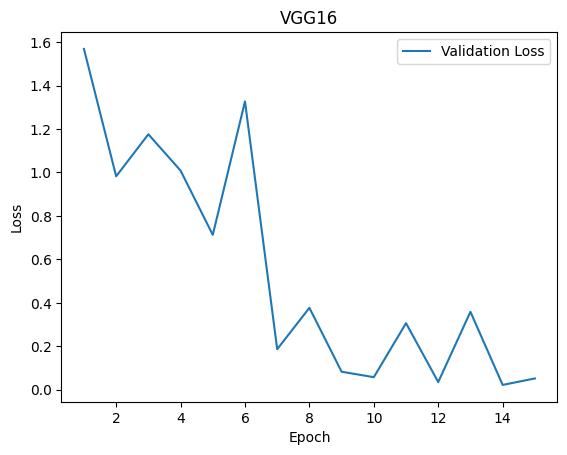

In [52]:
plot_loss(val_losses, 15, "VGG16")

In [53]:
# Convert lists to numpy arrays
incorrect_images_array = np.array(incorrect_images)
incorrect_labels_array = np.array(incorrect_labels)
correct_labels_array = np.array(correct_labels)

# Few sample wrong classifications
print(incorrect_images_array.shape)

# Reshape the array
reshaped_arr = incorrect_images_array.reshape((incorrect_images_array.shape[0], 3, 224, 224))

# Few sample wrong classifications
print(reshaped_arr.shape)

(96, 1, 3, 224, 224)
(96, 3, 224, 224)


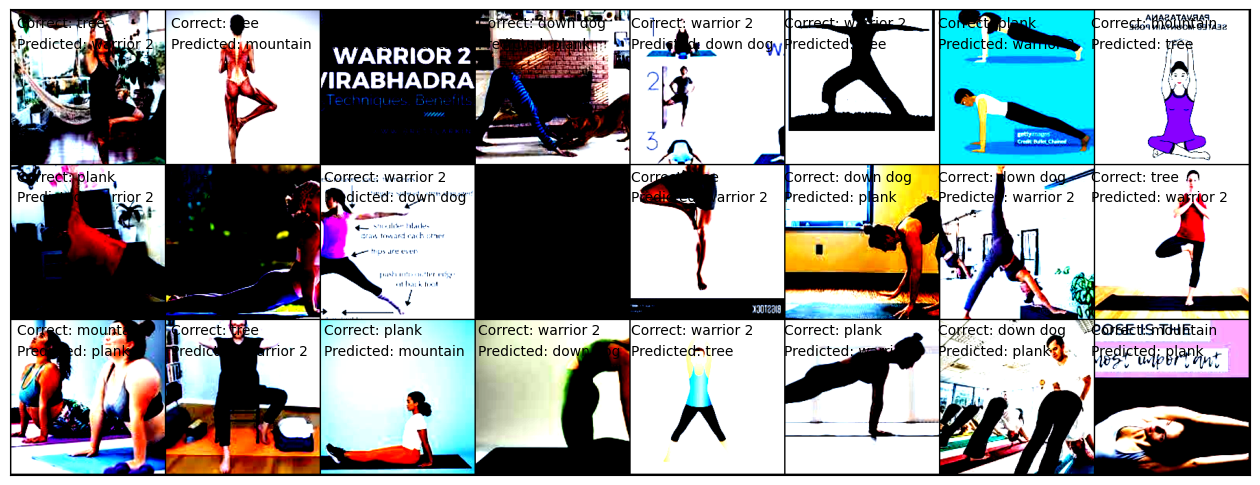

In [54]:
# Printing some sample images from the incorrect predictions
plt.figure(figsize=(16, 24))

# Select a subset of images to display
subset_images = reshaped_arr[:24]
subset_correct_labels = correct_labels[:24]
subset_predicted_labels = incorrect_labels[:24]


# Create a grid of images
grid_imgs = torchvision.utils.make_grid(torch.Tensor(subset_images))
np_grid_imgs = grid_imgs.numpy()

# Display the grid of images
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

lbls = ["down dog", "mountain", "plank", "tree", "warrior 2"]

# Display correct and predicted labels for each image
for i in range(len(subset_correct_labels)):
    # Add text on top of the image
    j = i%8
    k = i//8
    correct_label = lbls[subset_correct_labels[i][0]]
    pred_label = lbls[subset_predicted_labels[i][0]]
    plt.text(j * 224 + 10, k*224+10, f'Correct: {correct_label}', color='black', fontsize=10, ha='left', va='top')
    plt.text(j * 224 +10, k*224+40, f'Predicted: {pred_label}', color='black', fontsize=10, ha='left', va='top')

plt.show()

In [55]:
!pip install torch transformers

In [56]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [ ]:
# Load ViT feature extractor and model and the pretrained weights
feature_extractor = ViTFeatureExtractor("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=5)
model.to(device)
print(model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# Define loss function and optimizer
# We are going to use the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# We are using a Adam optimizer with a learning rate of 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model (first stage)
num_epochs = 5
best_val_acc = 0.0
# Number of epochs to wait for improvement before stopping
patience = 3
# Counter for patience
counter = 0

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    # Load inputs, labels from each batch of training set
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        # Move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # This method is used to reset the gradients of the model's parameters before computing gradients in a new forward pass
        optimizer.zero_grad()
        # This is the forward propagation of the Resnet18 model.
        outputs = model(inputs)
        # Calculating the cross-entropy loss for this forward pass.
        loss = criterion(outputs.logits, labels)
        # This step initiates the process of backpropagation, where gradients are computed for each parameter in the model with respect to the loss.
        # Backpropagation calculates how much each parameter should be adjusted to reduce the loss.
        loss.backward()
        # It is used to update the model's parameters (weights and biases) based on the gradients computed during the backward pass (backpropagation)/previous step.
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    # This disables gradient computation and updates
    with torch.no_grad():
        # variable to track total loss
        total_loss = 0
        # variable to track correct predictions
        correct_val = 0
        # variable to track size of validation set
        total_val = 0
        # Looping through each batch in validation set
        for inputs_val, labels_val in val_loader:
            # Move the data to GPU
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            # This is the forward propagation of the model
            outputs_val = model(inputs_val)
            # Get the class associated with the maximum value/probability
            _, predicted_val = torch.max(outputs_val.logits, 1)
            # Updating the total loss with the loss of the batch
            total_loss += loss.item()
            # Updating the total size of validations set
            total_val += labels_val.size(0)
            # Updating the total correct predictions
            correct_val += (predicted_val == labels_val).sum()

        # Calculate the validation loss by dividing the total validation loss by the validation set size
        validation_loss = total_loss / len(val_loader)
        # Calculating the validation accuracy
        val_acc = (correct_val / total_val) * 100
        print(f"Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_vit.pth")
            # reset the counter
            counter = 0
        else:
            # Early Stopping
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/5: 100%|██████████| 28/28 [00:26<00:00,  1.07batch/s]


Epoch 1, Validation Loss: 0.6139, Validation Accuracy: 83.03%


Epoch 2/5: 100%|██████████| 28/28 [00:26<00:00,  1.07batch/s]


Epoch 2, Validation Loss: 0.7301, Validation Accuracy: 81.65%


Epoch 3/5: 100%|██████████| 28/28 [00:25<00:00,  1.08batch/s]


Epoch 3, Validation Loss: 0.3210, Validation Accuracy: 86.70%


Epoch 4/5: 100%|██████████| 28/28 [00:26<00:00,  1.08batch/s]


Epoch 4, Validation Loss: 0.1383, Validation Accuracy: 85.32%


Epoch 5/5: 100%|██████████| 28/28 [00:26<00:00,  1.08batch/s]


Epoch 5, Validation Loss: 0.5692, Validation Accuracy: 84.40%


In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_model_vit.pth"))

# Lists to store incorrect predictions
incorrect_images = []
incorrect_labels = []
correct_labels = []

# Evaluate the model on the test set
model.eval()
# Testing
# This disables gradient computation and updates
with torch.no_grad():
    # Variables for tracking the size of test set and the number of correct predictions in test set
    correct_test = 0
    total_test = 0
    # Looping through each batch in test set
    for inputs_test, labels_test in test_loader:
        # Move the data to GPU
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        # This is the forward propagation of the model
        outputs_test = model(inputs_test)
        # Get the class associated with the maximum value/probability
        _, predicted_test = torch.max(outputs_test.logits, 1)
        # Storing incorrect prediction details
        if predicted_test != labels_test:
            incorrect_images.append(inputs_test[predicted_test != labels_test].cpu().numpy())
            incorrect_labels.append(predicted_test[predicted_test != labels_test].cpu().numpy())
            correct_labels.append(labels_test[predicted_test != labels_test].cpu().numpy())
        # Updating the total size of test set
        total_test += labels_test.size(0)
        # Updating the total correct predictions
        correct_test += (predicted_test == labels_test).sum()

test_acc = (correct_test / total_test) * 100
print(f"Total: {total_test}")
print(f"correct: {correct_test}")
print(f"Test Accuracy: {test_acc}")

Total: 272
correct: 232
Test Accuracy: 85.29411315917969


In [ ]:
# Convert lists to numpy arrays
incorrect_images_array = np.array(incorrect_images)
incorrect_labels_array = np.array(incorrect_labels)
correct_labels_array = np.array(correct_labels)

# Few sample wrong classifications
print(incorrect_images_array.shape)

# Reshape the array
reshaped_arr = incorrect_images_array.reshape((incorrect_images_array.shape[0], 3, 224, 224))

# Few sample wrong classifications
print(reshaped_arr.shape)

(40, 1, 3, 224, 224)
(40, 3, 224, 224)


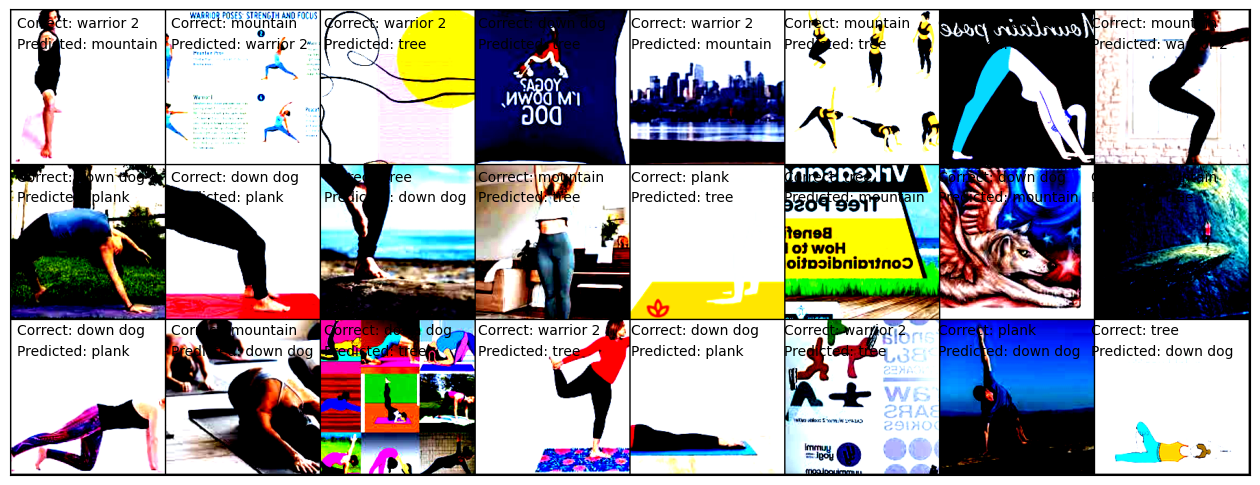

In [ ]:
# Printing some sample images from the incorrect predictions
plt.figure(figsize=(16, 24))

# Select a subset of images to display
subset_images = reshaped_arr[:24]
subset_correct_labels = correct_labels[:24]
subset_predicted_labels = incorrect_labels[:24]


# Create a grid of images
grid_imgs = torchvision.utils.make_grid(torch.Tensor(subset_images))
np_grid_imgs = grid_imgs.numpy()

# Display the grid of images
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

lbls = ["down dog", "mountain", "plank", "tree", "warrior 2"]

# Display correct and predicted labels for each image
for i in range(len(subset_correct_labels)):
    # Add text on top of the image
    j = i%8
    k = i//8
    correct_label = lbls[subset_correct_labels[i][0]]
    pred_label = lbls[subset_predicted_labels[i][0]]
    plt.text(j * 224 + 10, k*224+10, f'Correct: {correct_label}', color='black', fontsize=10, ha='left', va='top')
    plt.text(j * 224 +10, k*224+40, f'Predicted: {pred_label}', color='black', fontsize=10, ha='left', va='top')

plt.show()

In [ ]:
from transformers import BeitForImageClassification

In [ ]:
model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224-pt22k", num_labels=5)
model.to(device)
print(model)

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/368M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.weight', 'classifier.bias', 'beit.pooler.layernorm.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (relative_position_bias): BeitRelativePositionBias()
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediat

In [ ]:
# Define loss function and optimizer
# We are going to use the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# We are using a Adam optimizer with a learning rate of 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model (first stage)
num_epochs = 10
best_val_acc = 0.0
# Number of epochs to wait for improvement before stopping
patience = 3
# Counter for patience
counter = 0

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()
    # Load inputs, labels from each batch of training set
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        # Move the data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # This method is used to reset the gradients of the model's parameters before computing gradients in a new forward pass
        optimizer.zero_grad()
        # This is the forward propagation of the Resnet18 model.
        outputs = model(inputs)
        # Calculating the cross-entropy loss for this forward pass.
        loss = criterion(outputs.logits, labels)
        # This step initiates the process of backpropagation, where gradients are computed for each parameter in the model with respect to the loss.
        # Backpropagation calculates how much each parameter should be adjusted to reduce the loss.
        loss.backward()
        # It is used to update the model's parameters (weights and biases) based on the gradients computed during the backward pass (backpropagation)/previous step.
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    # This disables gradient computation and updates
    with torch.no_grad():
        # variable to track total loss
        total_loss = 0
        # variable to track correct predictions
        correct_val = 0
        # variable to track size of validation set
        total_val = 0
        # Looping through each batch in validation set
        for inputs_val, labels_val in val_loader:
            # Move the data to GPU
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            # This is the forward propagation of the model
            outputs_val = model(inputs_val)
            # Get the class associated with the maximum value/probability
            _, predicted_val = torch.max(outputs_val.logits, 1)
            # Updating the total loss with the loss of the batch
            total_loss += loss.item()
            # Updating the total size of validations set
            total_val += labels_val.size(0)
            # Updating the total correct predictions
            correct_val += (predicted_val == labels_val).sum()

        # Calculate the validation loss by dividing the total validation loss by the validation set size
        validation_loss = total_loss / len(val_loader)
        # Calculating the validation accuracy
        val_acc = (correct_val / total_val) * 100
        print(f"Epoch {epoch+1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_beit.pth")
            # reset the counter
            counter = 0
        else:
            # Early Stopping
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/10: 100%|██████████| 28/28 [00:27<00:00,  1.03batch/s]


Epoch 1, Validation Loss: 1.7732, Validation Accuracy: 62.39%


Epoch 2/10: 100%|██████████| 28/28 [00:27<00:00,  1.03batch/s]


Epoch 2, Validation Loss: 0.4657, Validation Accuracy: 63.30%


Epoch 3/10: 100%|██████████| 28/28 [00:26<00:00,  1.04batch/s]


Epoch 3, Validation Loss: 2.0203, Validation Accuracy: 65.60%


Epoch 4/10: 100%|██████████| 28/28 [00:27<00:00,  1.03batch/s]


Epoch 4, Validation Loss: 0.3207, Validation Accuracy: 72.94%


Epoch 5/10: 100%|██████████| 28/28 [00:27<00:00,  1.04batch/s]


Epoch 5, Validation Loss: 0.1977, Validation Accuracy: 66.97%


Epoch 6/10: 100%|██████████| 28/28 [00:26<00:00,  1.04batch/s]


Epoch 6, Validation Loss: 0.0367, Validation Accuracy: 66.51%


Epoch 7/10: 100%|██████████| 28/28 [00:27<00:00,  1.04batch/s]


Epoch 7, Validation Loss: 0.0734, Validation Accuracy: 71.10%
Early stopping at epoch 7


In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_model_beit.pth"))

# Lists to store incorrect predictions
incorrect_images = []
incorrect_labels = []
correct_labels = []

# Evaluate the model on the test set
model.eval()
# Testing
# This disables gradient computation and updates
with torch.no_grad():
    # Variables for tracking the size of test set and the number of correct predictions in test set
    correct_test = 0
    total_test = 0
    # Looping through each batch in test set
    for inputs_test, labels_test in test_loader:
        # Move the data to GPU
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        # This is the forward propagation of the model
        outputs_test = model(inputs_test)
        # Get the class associated with the maximum value/probability
        _, predicted_test = torch.max(outputs_test.logits, 1)
        # Storing incorrect prediction details
        if predicted_test != labels_test:
            incorrect_images.append(inputs_test[predicted_test != labels_test].cpu().numpy())
            incorrect_labels.append(predicted_test[predicted_test != labels_test].cpu().numpy())
            correct_labels.append(labels_test[predicted_test != labels_test].cpu().numpy())
        # Updating the total size of test set
        total_test += labels_test.size(0)
        # Updating the total correct predictions
        correct_test += (predicted_test == labels_test).sum()

test_acc = (correct_test / total_test) * 100
print(f"Total: {total_test}")
print(f"correct: {correct_test}")
print(f"Test Accuracy: {test_acc}")

Total: 272
correct: 202
Test Accuracy: 74.26470184326172


In [ ]:
# Convert lists to numpy arrays
incorrect_images_array = np.array(incorrect_images)
incorrect_labels_array = np.array(incorrect_labels)
correct_labels_array = np.array(correct_labels)

# Few sample wrong classifications
print(incorrect_images_array.shape)

# Reshape the array
reshaped_arr = incorrect_images_array.reshape((incorrect_images_array.shape[0], 3, 224, 224))

# Few sample wrong classifications
print(reshaped_arr.shape)

(70, 1, 3, 224, 224)
(70, 3, 224, 224)


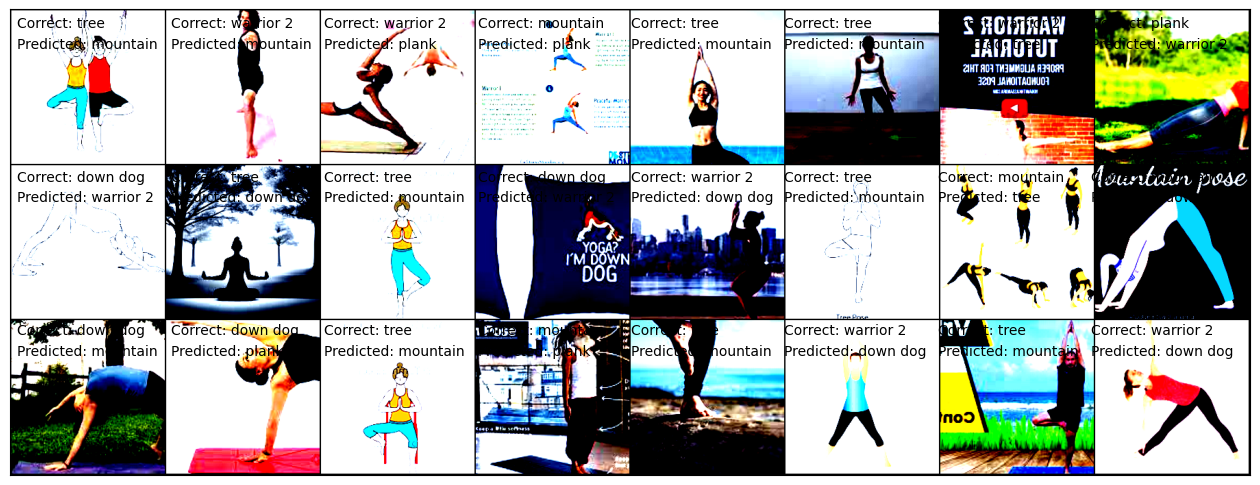

In [ ]:
# Printing some sample images from the incorrect predictions
plt.figure(figsize=(16, 24))

# Select a subset of images to display
subset_images = reshaped_arr[:24]
subset_correct_labels = correct_labels[:24]
subset_predicted_labels = incorrect_labels[:24]


# Create a grid of images
grid_imgs = torchvision.utils.make_grid(torch.Tensor(subset_images))
np_grid_imgs = grid_imgs.numpy()

# Display the grid of images
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

# Remove x and y ticks
plt.xticks([])
plt.yticks([])

lbls = ["down dog", "mountain", "plank", "tree", "warrior 2"]

# Display correct and predicted labels for each image
for i in range(len(subset_correct_labels)):
    # Add text on top of the image
    j = i%8
    k = i//8
    correct_label = lbls[subset_correct_labels[i][0]]
    pred_label = lbls[subset_predicted_labels[i][0]]
    plt.text(j * 224 + 10, k*224+10, f'Correct: {correct_label}', color='black', fontsize=10, ha='left', va='top')
    plt.text(j * 224 +10, k*224+40, f'Predicted: {pred_label}', color='black', fontsize=10, ha='left', va='top')

plt.show()